<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Image_Super_Resolution_using_an_Efficient_Sub_Pixel_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

from IPython.display import display

In [ ]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

In [ ]:
crop_size = 300
upscale_factor = 3
input_size=  crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(root_dir, batch_size=batch_size, image_size=(crop_size, crop_size), validation_split=0.2, subset='training', seed=1337, label_mode=None)

valid_ds = image_dataset_from_directory(root_dir, batch_size=batch_size, image_size=(crop_size, crop_size), validation_split=0.2, subset= 'validation', seed = 1337, label_mode = None)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


In [ ]:
image = next(iter(train_ds))
image = image[0] /255.

In [ ]:
image.shape

TensorShape([300, 300, 3])

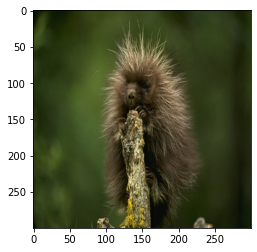

In [ ]:
plt.imshow(image)

In [ ]:
def scaling(input_image):
  input_image = input_image / 255.0
  return input_image 

# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

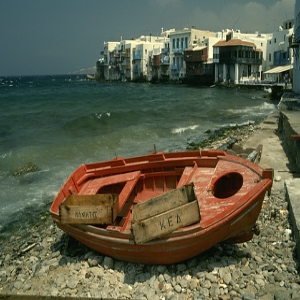

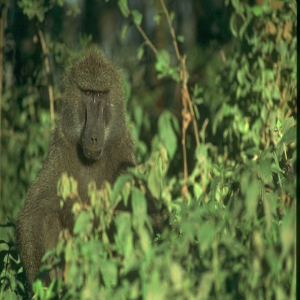

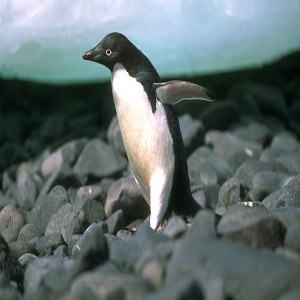

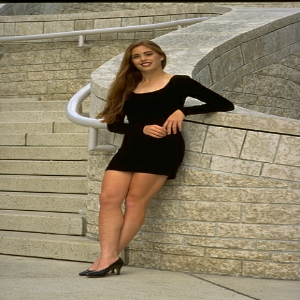

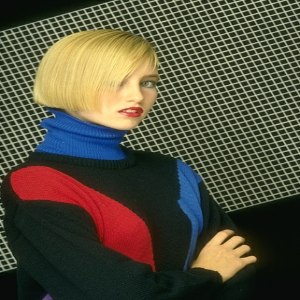

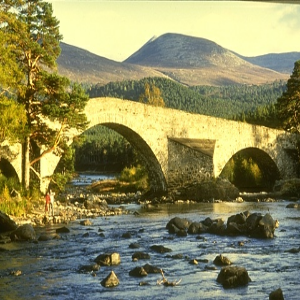

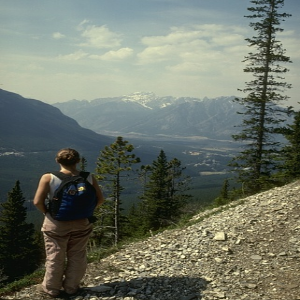

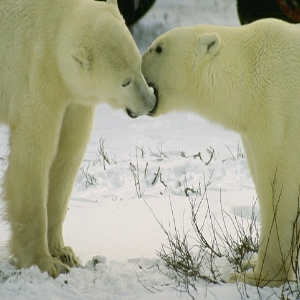

In [ ]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

In [ ]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

In [ ]:
test_img_paths = sorted([os.path.join(test_path, fname) for fname in os.listdir(test_path) if fname.endswith('.jpg')])

In [ ]:
test_img_paths

['/root/.keras/datasets/BSR/BSDS500/data/images/test/100007.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100039.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100099.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/10081.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/101027.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/101084.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/102062.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/103006.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/103029.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/103078.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/104010.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/104055.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/105027.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/106005.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/106047.jpg',
 '/root/.ke

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


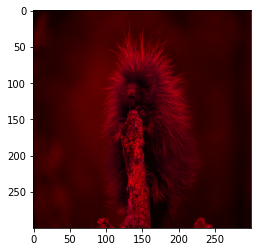

In [ ]:
plt.imshow(tf.image.rgb_to_yuv(image))

In [ ]:
def process_input(input, input_size, upscale_factor):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis = len(input.shape) - 1 
  y, u, v = tf.split(input, 3, axis = last_dimension_axis)
  return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
  input = tf.image.rgb_to_yuv(input)
  last_dimension_axis = len(input.shape) -1
  y, u, v = tf.split(input, 3, axis = last_dimension_axis)
  return y 


train_ds = train_ds.map(lambda x: (process_input(x, input_size, upscale_factor), process_target(x)))
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

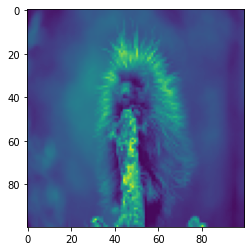

In [ ]:
image_p = process_input(image, input_size, upscale_factor)
plt.imshow(image_p[:,:,0])

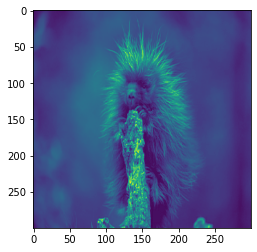

In [ ]:
image_n = process_target(image)
plt.imshow(image_n[:,:,0])

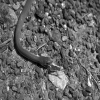

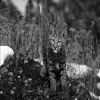

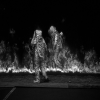

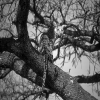

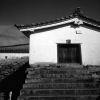

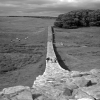

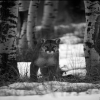

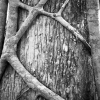

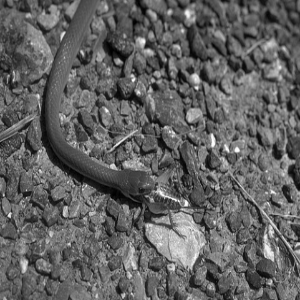

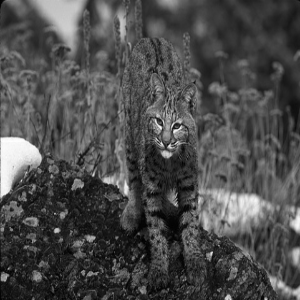

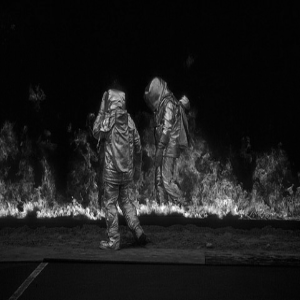

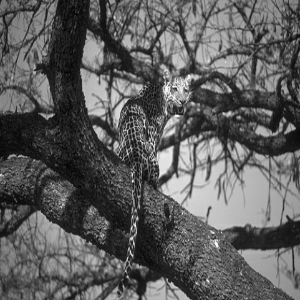

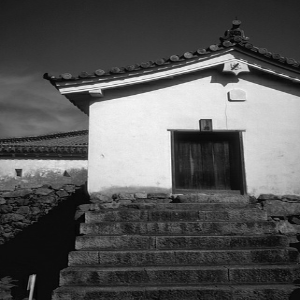

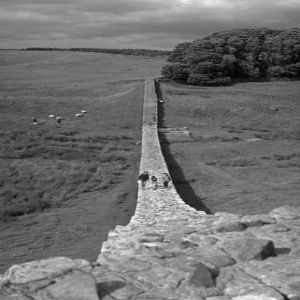

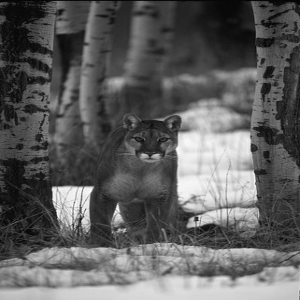

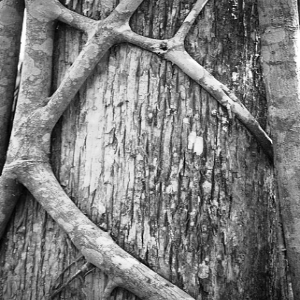

In [ ]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [ ]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

In [ ]:
def plot_results(img, prefix, title):
  img_array = img_to_array(img)
  img_array = img_array.astype('float32') / 255.0
  
  fig, ax = plt.subplots()
  im = ax.imshow(img_array[::-1], origin = 'lower')
  plt.title(title)
  # zoom-factor: 2.0, location: upper-left
  axins = zoomed_inset_axes(ax, 2, loc=2)
  axins.imshow(img_array[::-1], origin = 'lower')

  # Specify the limits.
  x1, x2, y1, y2 = 200, 300, 100, 200
  # Apply the x-limits.
  axins.set_xlim(x1, x2)
  # Apply the y-limits.
  axins.set_ylim(y1, y2)

  plt.yticks(visible=False)
  plt.xticks(visible=False)

  # Make the line.
  mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
  plt.savefig(str(prefix) + "-" + title + ".png")
  plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [ ]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_________________________________________________________

In [ ]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

Epoch 1/100
50/50 - 3s - loss: 0.0049 - val_loss: 0.0034
Mean PSNR for epoch: 24.51


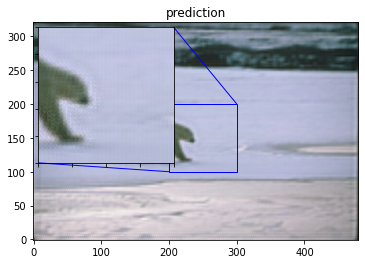

Epoch 2/100
50/50 - 3s - loss: 0.0034 - val_loss: 0.0028
Mean PSNR for epoch: 25.78
Epoch 3/100
50/50 - 3s - loss: 0.0030 - val_loss: 0.0026
Mean PSNR for epoch: 26.37
Epoch 4/100
50/50 - 3s - loss: 0.0029 - val_loss: 0.0027
Mean PSNR for epoch: 25.83
Epoch 5/100
50/50 - 3s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.29
Epoch 6/100
50/50 - 3s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.31
Epoch 7/100
50/50 - 3s - loss: 0.0028 - val_loss: 0.0024
Mean PSNR for epoch: 26.29
Epoch 8/100
50/50 - 3s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.45
Epoch 9/100
50/50 - 3s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.11
Epoch 10/100
50/50 - 3s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.36
Epoch 11/100
50/50 - 3s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.12
Epoch 12/100
50/50 - 3s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.35
Epoch 13/100
50/50 - 3s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for e

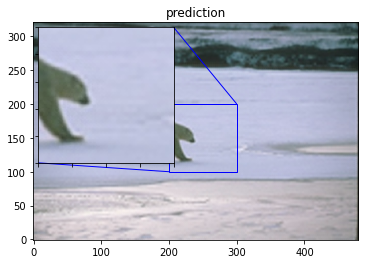

Epoch 22/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.68
Epoch 23/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.75
Epoch 24/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 27.11
Epoch 25/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.38
Epoch 26/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 27.27
Epoch 27/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.60
Epoch 28/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.67
Epoch 29/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.50
Epoch 30/100
50/50 - 3s - loss: 0.0030 - val_loss: 0.0037
Mean PSNR for epoch: 24.27
Epoch 31/100
50/50 - 3s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.54
Epoch 32/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.96
Epoch 33/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PS

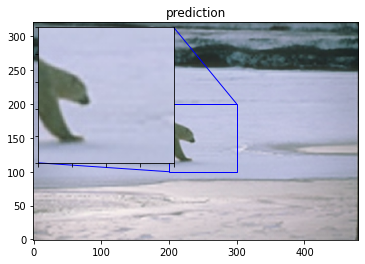

Epoch 42/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.89
Epoch 43/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.89
Epoch 44/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.50
Epoch 45/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.28
Epoch 46/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.59
Epoch 47/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.31
Epoch 48/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.57
Epoch 49/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.41
Epoch 50/100
50/50 - 3s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.52
Epoch 51/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0022
Mean PSNR for epoch: 26.48
Epoch 52/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.95
Epoch 53/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PS

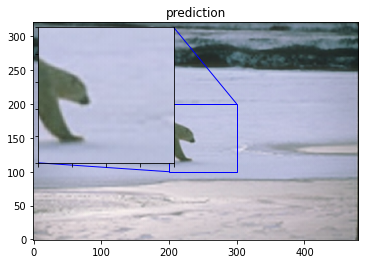

Epoch 62/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.34
Epoch 63/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 27.36
Epoch 64/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.90
Epoch 65/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.44
Epoch 66/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.67
Epoch 67/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.72
Epoch 68/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.47
Epoch 69/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.74
Epoch 70/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.73
Epoch 71/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.89
Epoch 72/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.74
Epoch 73/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PS

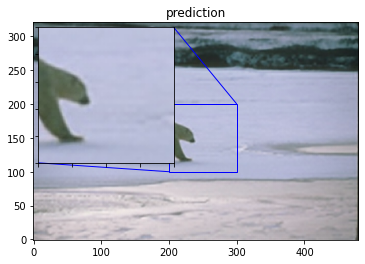

Epoch 82/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.86
Epoch 83/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.73
Epoch 84/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR for epoch: 26.40
Epoch 85/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.14
Epoch 86/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.50
Epoch 87/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.32
Epoch 88/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.60
Epoch 89/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.41
Epoch 90/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.37
Epoch 91/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.85
Epoch 92/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.86
Epoch 93/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0022
Mean PS

In [ ]:
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

PSNR of low resolution image and high resolution image is 29.8502
PSNR of predict and high resolution is 30.4168


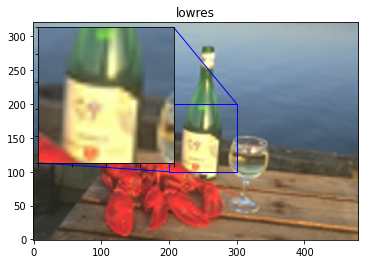

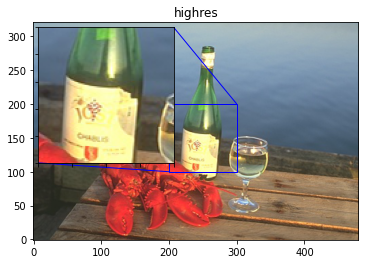

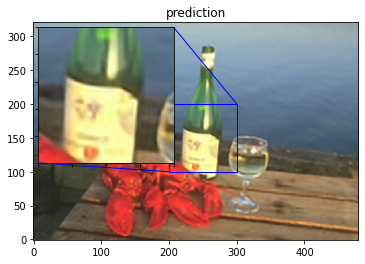

PSNR of low resolution image and high resolution image is 24.9783
PSNR of predict and high resolution is 25.9814


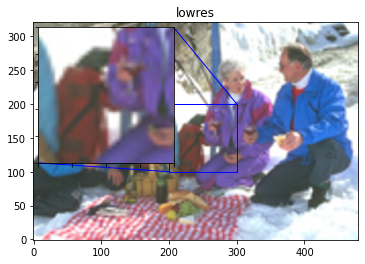

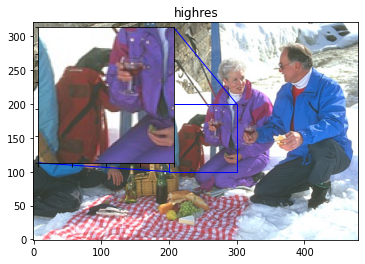

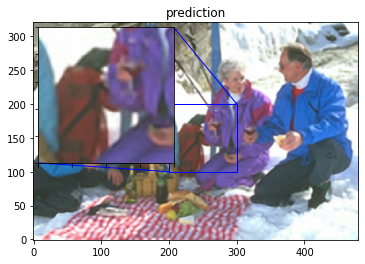

PSNR of low resolution image and high resolution image is 27.7724
PSNR of predict and high resolution is 28.4196


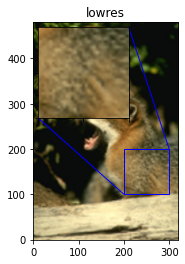

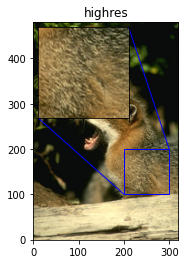

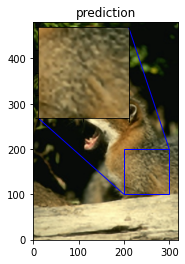

PSNR of low resolution image and high resolution image is 28.0314
PSNR of predict and high resolution is 28.2984


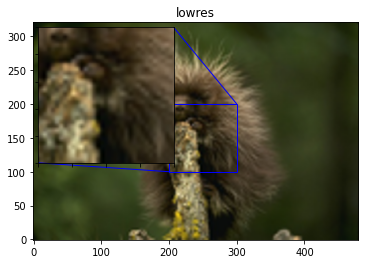

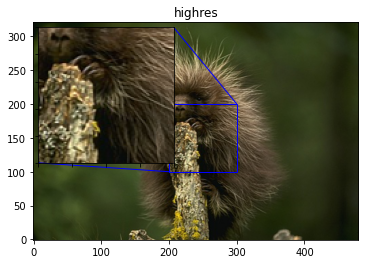

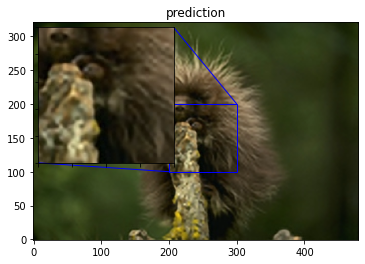

PSNR of low resolution image and high resolution image is 25.7630
PSNR of predict and high resolution is 26.3306


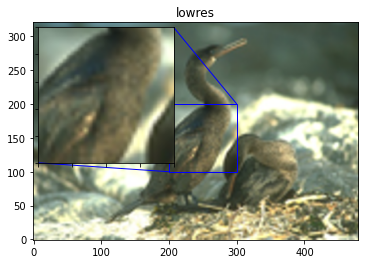

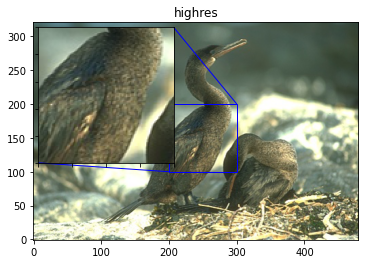

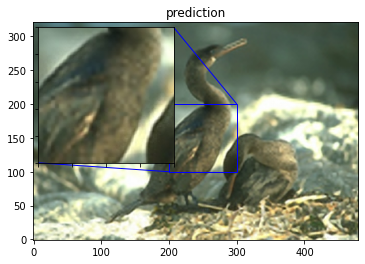

PSNR of low resolution image and high resolution image is 25.7874
PSNR of predict and high resolution is 26.5596


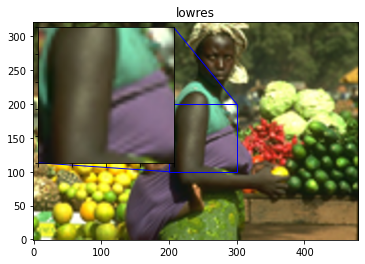

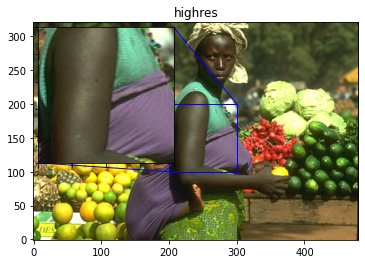

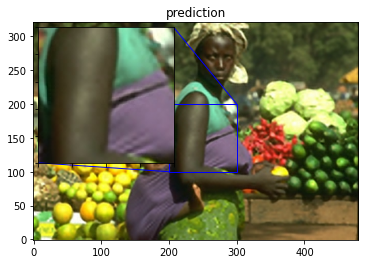

PSNR of low resolution image and high resolution image is 26.2512
PSNR of predict and high resolution is 27.1613


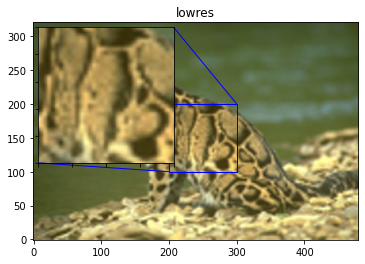

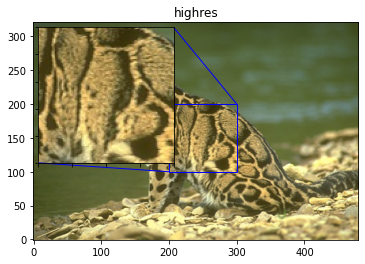

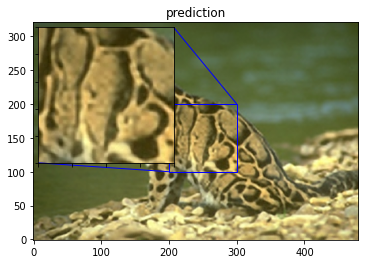

PSNR of low resolution image and high resolution image is 23.3820
PSNR of predict and high resolution is 24.7562


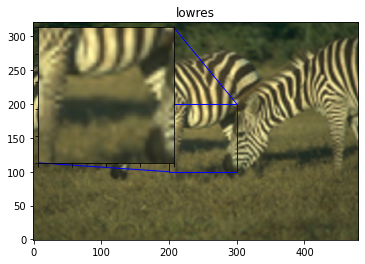

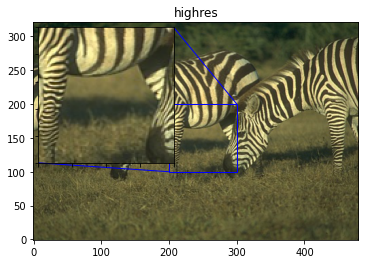

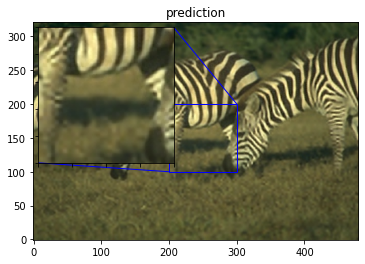

PSNR of low resolution image and high resolution image is 29.8914
PSNR of predict and high resolution is 30.0712


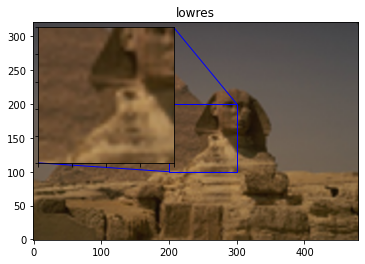

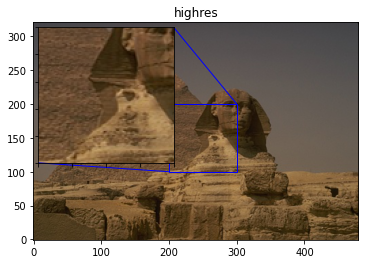

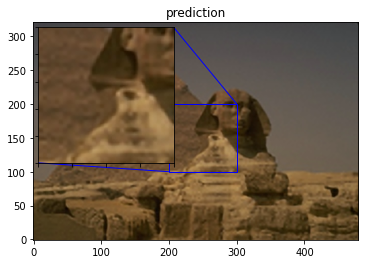

PSNR of low resolution image and high resolution image is 25.1712
PSNR of predict and high resolution is 25.6939


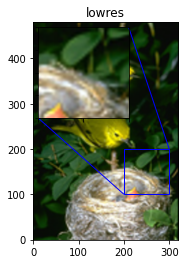

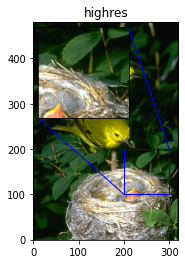

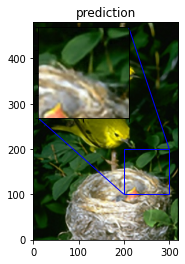

Avg. PSNR of lowres images is 26.6879
Avg. PSNR of reconstructions is 27.3689


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))